In [5]:
#Problem Setup/Definition:
import numpy as np
np.random.seed(42)
import random
random.seed(42)
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfTransformer
from string import punctuation
from string import digits
from nltk.corpus import wordnet
from sklearn.feature_extraction import text, stop_words
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.svm import LinearSVC
import math 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
from sklearn.naive_bayes import GaussianNB

cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)
%matplotlib inline

/usr/lib/python3/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/tmp/tmpf7681r52'", use "location='/tmp/tmpf7681r52'" instead.


In [2]:
def my_custom_preprocessor(doc_string):
    # do all data preprocessing here
    
    # Lower case
    doc_string=doc_string.lower()
    
    # Remove Numbers
    remove_digits = str.maketrans('', '', digits)
    doc_string.translate(remove_digits)
    
    # Convert to tokenized form....
    tokens = nltk.tokenize.word_tokenize(doc_string)
    # Iterate through list of tokens (words) and remove all numbers
    tokens = [word for word in tokens if word.isalpha()]
    # Iterate through list of tokens (words) and stem (shorten) each word
    port_stemmer = PorterStemmer()
    tokens = [port_stemmer.stem(words) for words in tokens ]
    
    ###############################
    #### Lemmatize with pos_tag ###
    ###############################
    
    lemmatizer = WordNetLemmatizer()
    
    # Convert between two different tagging schemes
    def change_tags(penntag):
        morphy_tag = {'NN':'n', 'JJ':'a',
                      'VB':'v', 'RB':'r'}
        try:
            return morphy_tag[penntag[:2]]
        except:
            return 'n'
        
    tokens = [lemmatizer.lemmatize(word.lower(), pos=change_tags(tag)) for word, tag in pos_tag(tokens)]
    
    # Rejoin List of tokens and return that single document-string
    return ' '.join(tokens)

###########################
#### RoC Curve Function ###
###########################

def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

def fit_predict_and_plot_roc(pipe, train_data, train_label, test_data, test_label):
    pipe.fit(train_data, train_label)

    if hasattr(pipe, 'decision_function'):
        prob_score = pipe.decision_function(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score)
    else:
        prob_score = pipe.predict_proba(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score[:,1])

    plot_roc(fpr, tpr)
    
#####################################################
#### Define Custom stop words for CountVectorizer ###
#####################################################

stop_words_skt = text.ENGLISH_STOP_WORDS
stop_words_en = stopwords.words('english')
combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))

# Run stop_words through the same pre-processor as the document-matrix
# This will apply stemmed/lemmatized stop_woirds to stemmed/lemmatized tokenized document lists
def process_stop_words(stop_word_set):
    doc_string = ' '.join(stop_word_set)
    return my_custom_preprocessor(doc_string).split()

##################################
#### Import Dataset Train/Test ###
##################################

# Only take a specific selection (8) of the 20 available categories
categories = ['comp.graphics', 'comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles',
'rec.sport.baseball', 'rec.sport.hockey']

# Load a training & test data sets consisting of those 8 categories
train_dataset = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = None)
test_dataset = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = None)
print("\n\n" + '-'*40 + "\n\n")

#############################################
#### Define Class data set arrys (0 or 1) ###
#############################################
# Categorize the 8 news categories into two (binary) Classes 
# 0 = computer technology
# 1 = recreational activity
training_data_class = [] 
test_data_class = []

# Categories are mapped 0-7, (0-3) = Comp, (4-7) = Recreation
print(train_dataset.target_names)
print(train_dataset.target)

for category in train_dataset.target:
    if category < 4:
        training_data_class.append(0)
    else:
        training_data_class.append(1)
        
# Reshape test dataset
for category in test_dataset.target:
    if category < 4:
        test_data_class.append(0)
    else:
        test_data_class.append(1)
        
# Sanity Checks, values should all be either 1 or 0
print("First 10 articles Classification (Train): \n" + str(training_data_class[0:10]))
print("First 10 articles Classification (Train): \n" + str(test_data_class[0:10]))
# This will be used for the classification categories only!!!!
# Each data point refers to the classification of a single article in dataset



----------------------------------------


['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
[6 7 4 ... 6 6 2]
First 10 articles Classification (Train): 
[1, 1, 1, 0, 0, 0, 0, 1, 1, 0]
First 10 articles Classification (Train): 
[1, 0, 0, 1, 1, 1, 1, 1, 1, 1]


In [3]:
# Define the CountVectorizer = document-term matrix
train_count_vectorizer = CountVectorizer(min_df=3, preprocessor=my_custom_preprocessor, stop_words=process_stop_words(combined_stopwords))
test_count_vectorizer = CountVectorizer(min_df=3, preprocessor=my_custom_preprocessor, stop_words=process_stop_words(combined_stopwords))

# Fit + count the train_doc_term_matrix: setting the vocabulary (word-features) based on words found in the train_dataset
train_doc_term_matrix = train_count_vectorizer.fit_transform(train_dataset.data)

# Fit the test_count_doc_term_matric to train_dataset words; then count the occurence of those words in the test_dataset
test_count_vectorizer.fit(train_dataset.data)
test_count_doc_term_matrix = test_count_vectorizer.transform(test_dataset.data)

# Start TD-DIF Transform process; created TDIF matrix with train_doc_term_matrix vocabulary; apply test_dataset transform
tfidf_transformer = TfidfTransformer()
train_tfidf = tfidf_transformer.fit_transform(train_doc_term_matrix)
test_tfidf = tfidf_transformer.fit_transform(test_count_doc_term_matrix)

print("Number of articles within the TRAIN Dataset: " + str(len(train_dataset.filenames)))
print("Number of Features (unique words) in TRAINING dataset (After Processing): "+ str(len(train_count_vectorizer.get_feature_names())))
print("Shape of TRAINING document-count-matrix: " + str(train_doc_term_matrix.shape))
print("Shape of TRAINING TF-IDF Matrix: " + str(train_tfidf.shape))
print("\n\n" + '-'*40 + "\n\n")

print("Number of articles within the TEST Dataset: " + str(len(test_dataset.filenames)))
print("Number of Features (unique words) in TEST dataset (After Processing): "+ str(len(test_count_vectorizer.get_feature_names())))
print("Shape of TEST document-count-matrix: " + str(test_count_doc_term_matrix.shape))
print("Shape of TEST TF-IDF Matrix: " + str(test_tfidf.shape))
print("\n\n" + '-'*40 + "\n\n")


##############################
## Dimensionality Reduction ##
##############################
# Only need on SVD Model, Choosing NMF
from sklearn.decomposition import NMF

nmf_settings = NMF(n_components=50, init='random', random_state=0)
reduced_NMF_train_matrix = nmf_settings.fit_transform(train_tfidf)
reduced_NMF_test_matrix = nmf_settings.transform(test_tfidf)

nmf_settings_components = nmf_settings.components_
print("Shape of reduced TRAIN tf-idf matrix after NMF Dimensionality Reduction (top 50 words): " + str(reduced_NMF_train_matrix.shape))
print("Shape of reduced TEST tf-idf matrix after NMF Dimensionality Reduction (top 50 words): " + str(reduced_NMF_train_matrix.shape))


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['anywh', 'becau', 'elsewh', 'everywh', 'ind', 'otherwi', 'somewh'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Number of articles within the TRAIN Dataset: 4732
Number of Features (unique words) in TRAINING dataset (After Processing): 10847
Shape of TRAINING document-count-matrix: (4732, 10847)
Shape of TRAINING TF-IDF Matrix: (4732, 10847)


----------------------------------------


Number of articles within the TEST Dataset: 3150
Number of Features (unique words) in TEST dataset (After Processing): 10847
Shape of TEST document-count-matrix: (3150, 10847)
Shape of TEST TF-IDF Matrix: (3150, 10847)


----------------------------------------


Shape of reduced TRAIN tf-idf matrix after NMF Dimensionality Reduction (top 50 words): (4732, 50)
Shape of reduced TEST tf-idf matrix after NMF Dimensionality Reduction (top 50 words): (4732, 50)


############## Baive Bayes: Gaus Stats ############### 

Accuracy: 0.9561904761904761
Precision: 0.9389359129383313
Recall: 0.9767295597484277
Confusion Matrix: 
[[1459  101]
 [  37 1553]]
F1-score: [0.92788258 1.87787183 1.87787183 ... 1.87787183 0.92788258 1.87787183]


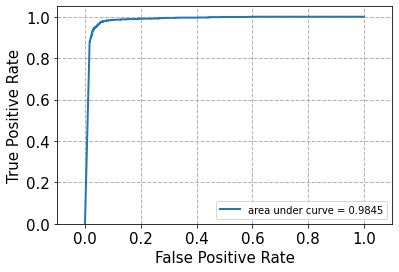

In [15]:
#######################################
## Naive Bayes Classifer: GaussianNB ##
#######################################
#Define the Gaussian model
train_gaus_model = GaussianNB().fit(reduced_NMF_train_matrix, training_data_class)
predict_gaus_model = train_gaus_model.predict(reduced_NMF_test_matrix)

# Plot Gaus Model Statistics:
gaus_accuracy = metrics.accuracy_score(test_data_class, predict_gaus_model)
gaus_precision = metrics.precision_score(test_data_class, predict_gaus_model)
gaus_recall = metrics.recall_score(test_data_class, predict_gaus_model)
gaus_f1 = 2 * (gaus_precision * gaus_recall) / (predict_gaus_model + gaus_recall)
print("############## Baive Bayes: Gaus Stats ############### \n")
print("Accuracy: " + str(gaus_accuracy))
print("Precision: " + str(gaus_precision))
print("Recall: " + str(gaus_recall))
print("Confusion Matrix: \n" + str(metrics.confusion_matrix(test_data_class, predict_gaus_model)))
print("F1-score: "+ str(gaus_f1))

# ROC Curve
dec_function_score = train_gaus_model.predict_proba(reduced_NMF_test_matrix)
fpr, tpr, thresholds = metrics.roc_curve(test_data_class, dec_function_score[:,1])
plot_roc(fpr,tpr)